In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
df = process_folder(path_to_data, path_to_output, files=[20], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T161448
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 240, 'bin_file': '2024-11-08T161448.bin'}
836458000 datapoints extracted
LABELS: 640 bubble labels with VeloOut != -1 extracted.

Missing Labels:
L_idx: L253, ExitIdx: 327054128, VeloOut: 1.92765
L_idx: L384, ExitIdx: 490162316, VeloOut: 2.32511
EXTRACTED: 638 bubbles have VeloOut != -1 out of 3502 total bubbles.
            bubble_idx E_idx L_idx  VeloOut  \
0  0_2024-11-08T161448    E0    -1 -1.00000   
1  1_2024-11-08T161448    E1    -1 -1.00000   
2  2_2024-11-08T161448    E2    L0  1.46359   
3  3_2024-11-08T161448    E3    -1 -1.00000   
4  4_2024-11-08T161448    E4    -1 -1.00000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5445722937583923, 0.5351115465164185, 0.561...       240  2.083333e+07  
1  [0.6279488801956177, 0.6237372756004333, 0.613...       240  2.08333

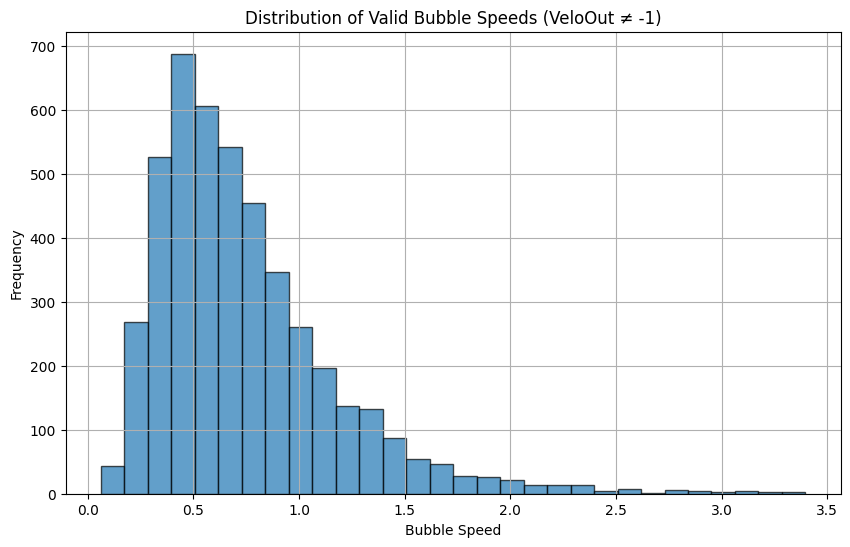

In [4]:
# Filter out invalid speeds
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [35]:
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [27]:
# with open(path_to_output+'/scalers/feature_scaler2-20%3.pkl', 'wb') as f:
#     pickle.dump(feature_scaler, f)

# with open(path_to_output+'/scalers/target_scaler2-20%3.pkl', 'wb') as f:
#     pickle.dump(target_scaler, f)

0.471768


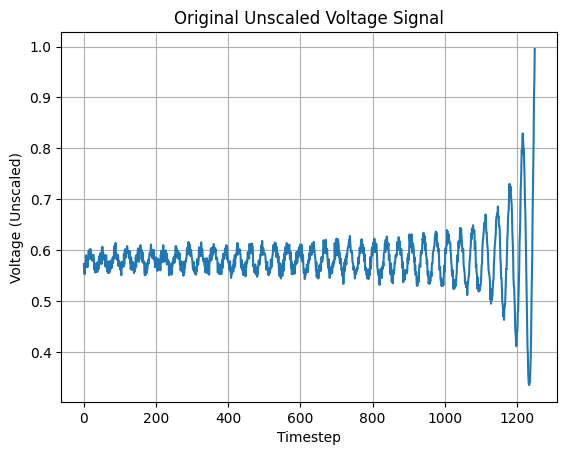

In [84]:
# Select a specific bubble by index (e.g., index 1)
i=101
voltage_signal = df["VoltageOut"].iloc[i]  # This is unscaled
print(df['VeloOut'].iloc[i])
# Create x-axis based on signal length
x = np.arange(len(voltage_signal))

# Plot
plt.plot(x, voltage_signal)
plt.title("Original Unscaled Voltage Signal")
plt.xlabel("Timestep")
plt.ylabel("Voltage (Unscaled)")
plt.grid(True)
plt.show()

In [36]:
chance = 0.3
bins = 30
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train_scaled, bins)
factors = calculate_duplication_factors(hist)
#X_train_scaled, y_train_scaled = duplicate_and_augment_data(X_train_scaled, y_train_scaled, bin_indices, factors, noise=0.005)
X_train_scaled, y_train_scaled = flatten_data_distribution(X_train_scaled, y_train_scaled, bins, scaling_factor=0.05, noise=0.005)

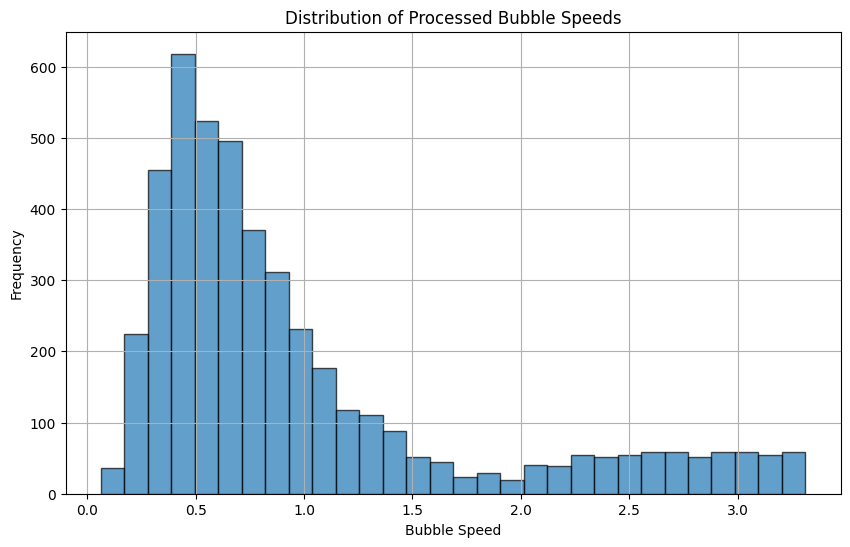

In [37]:
y_train_fig = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten() 
plt.figure(figsize=(10, 6))
plt.hist(y_train_fig, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Processed Bubble Speeds")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [38]:
X_train_scaled.shape

(4565, 1250)

In [39]:
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Epoch 1/5000 - Train Loss: 3.6559 - Val Loss: 1.0922
Epoch 100/5000 - Train Loss: 0.7078 - Val Loss: 0.4346
Epoch 200/5000 - Train Loss: 0.4183 - Val Loss: 0.2139
Epoch 300/5000 - Train Loss: 0.2852 - Val Loss: 0.1550
Epoch 400/5000 - Train Loss: 0.0636 - Val Loss: 0.0559
Epoch 500/5000 - Train Loss: 0.0613 - Val Loss: 0.0798
Epoch 600/5000 - Train Loss: 0.0534 - Val Loss: 0.0757
Epoch 700/5000 - Train Loss: 0.1539 - Val Loss: 0.0704
Epoch 800/5000 - Train Loss: 0.0407 - Val Loss: 0.0516
Epoch 900/5000 - Train Loss: 0.0293 - Val Loss: 0.0424
Epoch 1000/5000 - Train Loss: 0.0260 - Val Loss: 0.0395
Epoch 1100/5000 - Train Loss: 0.0239 - Val Loss: 0.0380
Epoch 1200/5000 - Train Loss: 0.0218 - Val Loss: 0.0392
Epoch 1300/5000 - Train Loss: 0.0330 - Val Loss: 0.0566
Epoch 1400/5000 - Train Loss: 0.0264 - Val Loss: 0.0437
Epoch 1500/5000 - Train Loss: 0.0682 - Val Loss: 0.0603
Epoch 1600/5000 - Train Loss: 0.0255 - Val Loss: 0.0328
Epoch 1700/5000 - Train Loss: 0.0638 - Val Loss: 0.0387
Epoc

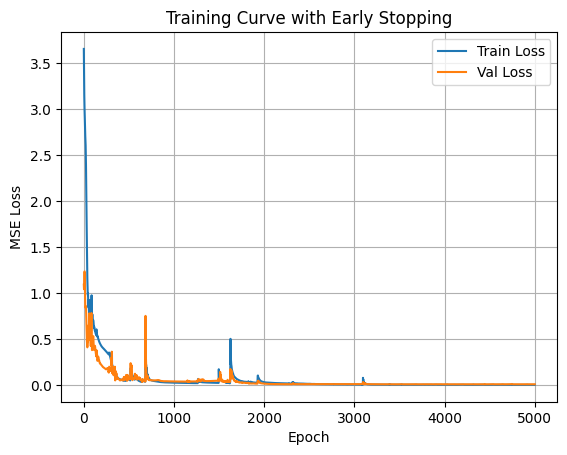

In [40]:
# Model setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.005)

# Early stopping parameters
patience = 3000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 5000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru1_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru1_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.002 cm/s
MAE: 0.017 cm/s
R² Score: 0.993


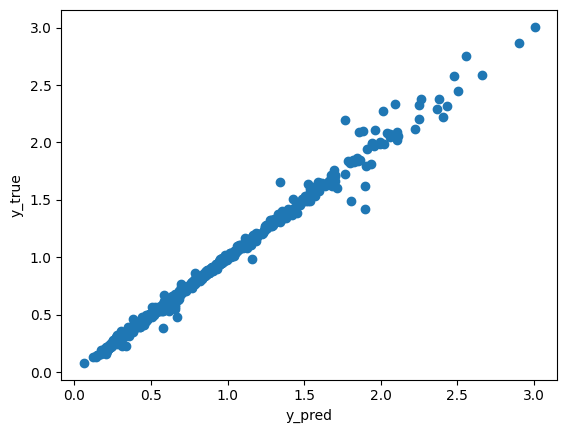

In [42]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

Epoch 1/6000 - Train Loss: 3.6356 - Val Loss: 1.1463
Epoch 250/6000 - Train Loss: 0.1855 - Val Loss: 0.1399
Epoch 500/6000 - Train Loss: 2.1905 - Val Loss: 0.6798
Epoch 750/6000 - Train Loss: 0.1705 - Val Loss: 0.1351
Epoch 1000/6000 - Train Loss: 0.0790 - Val Loss: 0.0865
Epoch 1250/6000 - Train Loss: 0.0653 - Val Loss: 0.0732
Epoch 1500/6000 - Train Loss: 0.0579 - Val Loss: 0.0671
Epoch 1750/6000 - Train Loss: 0.0496 - Val Loss: 0.0613
Epoch 2000/6000 - Train Loss: 0.0475 - Val Loss: 0.0605
Epoch 2250/6000 - Train Loss: 0.0403 - Val Loss: 0.0565
Epoch 2500/6000 - Train Loss: 0.0381 - Val Loss: 0.0539
Epoch 2750/6000 - Train Loss: 0.0361 - Val Loss: 0.0512
Epoch 3000/6000 - Train Loss: 0.0335 - Val Loss: 0.0513
Epoch 3250/6000 - Train Loss: 0.0377 - Val Loss: 0.0453
Epoch 3500/6000 - Train Loss: 0.0507 - Val Loss: 0.0452
Epoch 3750/6000 - Train Loss: 0.0308 - Val Loss: 0.0447
Epoch 4000/6000 - Train Loss: 0.0267 - Val Loss: 0.0438
Epoch 4250/6000 - Train Loss: 0.0498 - Val Loss: 0.036

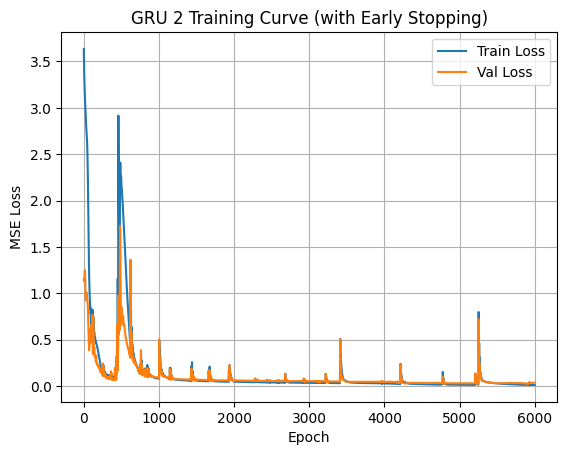

In [43]:
gru2_model = GRUModel(input_size=1, hidden_size=25, num_layers=2)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.002)
criterion = torch.nn.MSELoss()

# Early stopping setup
patience = 2000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training
epochs = 6000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru2_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 250 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    gru2_model.load_state_dict(best_model_state)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [44]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.006 cm/s
MAE: 0.025 cm/s
R² Score: 0.970


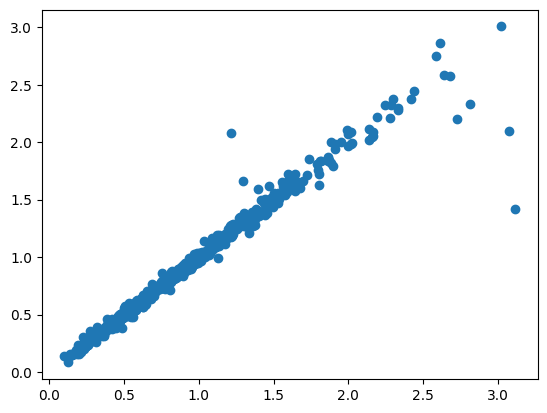

In [45]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

Epoch 1/40000 - Train Loss: 3.7480 - Val Loss: 1.1306
Epoch 500/40000 - Train Loss: 2.9495 - Val Loss: 1.0146
Epoch 1000/40000 - Train Loss: 2.8573 - Val Loss: 1.0058
Epoch 1500/40000 - Train Loss: 2.8180 - Val Loss: 0.9973
Epoch 2000/40000 - Train Loss: 2.7653 - Val Loss: 0.9817
Epoch 2500/40000 - Train Loss: 2.6969 - Val Loss: 0.9634
Epoch 3000/40000 - Train Loss: 2.6222 - Val Loss: 0.9489
Epoch 3500/40000 - Train Loss: 2.4995 - Val Loss: 0.9198
Epoch 4000/40000 - Train Loss: 2.2356 - Val Loss: 0.8681
Epoch 4500/40000 - Train Loss: 1.6385 - Val Loss: 0.7159
Epoch 5000/40000 - Train Loss: 0.8875 - Val Loss: 0.5242
Epoch 5500/40000 - Train Loss: 0.7754 - Val Loss: 0.4544
Epoch 6000/40000 - Train Loss: 0.5240 - Val Loss: 0.3711
Epoch 6500/40000 - Train Loss: 0.3397 - Val Loss: 0.3056
Epoch 7000/40000 - Train Loss: 0.2851 - Val Loss: 0.2657
Epoch 7500/40000 - Train Loss: 0.2447 - Val Loss: 0.2408
Epoch 8000/40000 - Train Loss: 0.2141 - Val Loss: 0.2232
Epoch 8500/40000 - Train Loss: 0.19

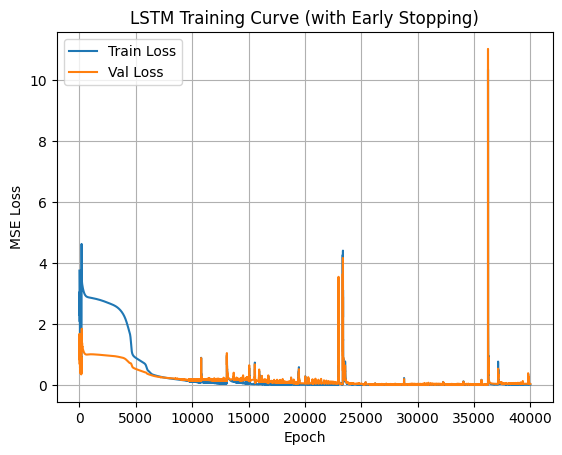

In [50]:
lstm_model = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.012)

# Early stopping setup
patience = 20000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 40000
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = lstm_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 500 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [51]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.006 cm/s
MAE: 0.036 cm/s
R² Score: 0.970


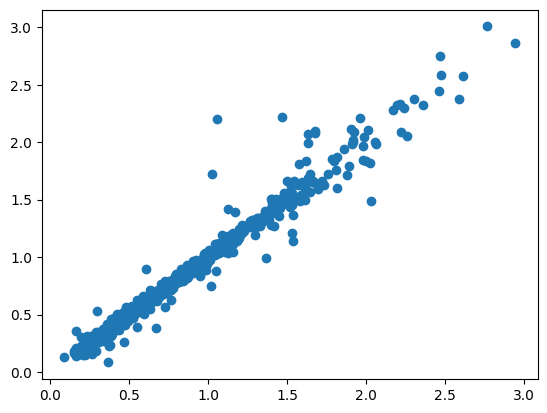

In [52]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

In [54]:

torch.save(gru1_model.state_dict(), path_to_output+"/models/gru20-5_2-20%3_is1_ns20_nl2_lr0.005_ep5000_r20.993")
torch.save(gru2_model.state_dict(), path_to_output+"/models/gru20-5_2-20%3_is1_ns25_nl2_lr0.002_ep6000_r20.970")
torch.save(lstm_model.state_dict(), path_to_output+"/models/lstm19-5_2-20%3_is1_ns18_nl2_lr0.01_ep40000_r20.970")